In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import joblib
from tqdm.notebook import tqdm

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 1. Read Data

In [3]:
df_train = pd.read_csv('../input/train.csv')

In [4]:
df_train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


# 2. Splits data

In [5]:
df_train['fold'] = pd.read_csv('../input/df_folds.csv')['fold']

In [6]:
trn_fold = [i for i in range(6) if i not in [5]]
vld_fold = [5]
trn_idx = df_train.loc[df_train['fold'].isin(trn_fold)].index
vld_idx = df_train.loc[df_train['fold'].isin(vld_fold)].index

In [7]:
trn_idx

Int64Index([     0,      1,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            200826, 200827, 200829, 200830, 200832, 200834, 200835, 200836,
            200837, 200838],
           dtype='int64', length=167367)

# Define dataset

In [8]:
class BengaliDataset(Dataset):
    def __init__(self, csv, img_height, img_width, transform):
        self.csv = csv.reset_index()
        self.img_ids = csv['image_id'].values
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(f'../input/train_images/{img_id}.pkl')
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        #img = 255 - img
        img = 255 - img
        #img = np.expand_dims(img, axis=2)
        
        img = img[:, :, np.newaxis]
        img = np.repeat(img, 3, 2)
        if self.transform is not None:
            img = self.transform(image=img)['image']
        
        label_1 = self.csv.iloc[index].grapheme_root
        label_2 = self.csv.iloc[index].vowel_diacritic
        label_3 = self.csv.iloc[index].consonant_diacritic
        
        return img, np.array([label_1, label_2, label_3])

# 4. Define augmentations

In [9]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Cutout, Rotate, HorizontalFlip, Normalize
)
from albumentations.pytorch import ToTensor, ToTensorV2

In [10]:
train_augmentation = Compose([
    Rotate(20),
    ToTensor()
])

valid_augmentation = Compose([
    ToTensor()
])

# Make dataloader

In [11]:
from torch.utils.data import Dataset, DataLoader

In [12]:
trn_dataset = BengaliDataset(csv=df_train.loc[trn_idx],
                            img_height=137,
                            img_width=236,
                            transform=train_augmentation)

vld_dataset = BengaliDataset(csv=df_train.loc[vld_idx],
                            img_height=137,
                            img_width=236,
                            transform=valid_augmentation)



In [13]:
trn_loader = DataLoader(trn_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=128
                       )

vld_loader = DataLoader(vld_dataset,
                       shuffle=False,
                        num_workers=4,
                        batch_size=128
                       )

# 5. Make model, optimzer, criterion

In [14]:
import pretrainedmodels

In [15]:
model_name = 'resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
in_features = model.last_linear.in_features
model.last_linear = torch.nn.Linear(in_features, 186)

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
model = model.cuda()

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                      mode='max',
                                                      verbose=True,
                                                      patience=7,
                                                      factor=0.5)

# training

In [23]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [24]:
for inputs, targets in tqdm(trn_loader):
    inputs = inputs.cuda()
    targets = targets.cuda()
    break

In [25]:
lam = np.random.beta(1.0, 1.0) 
rand_index = torch.randperm(inputs.size()[0])

In [26]:
targets_gra = targets[:, 0]
targets_vow = targets[:, 1]
targets_con = targets[:, 2]

In [27]:
shuffled_targets_gra = targets_gra[rand_index]
shuffled_targets_vow = targets_vow[rand_index]
shuffled_targets_con = targets_con[rand_index]

In [28]:
bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)

In [29]:
inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]

In [30]:
lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))

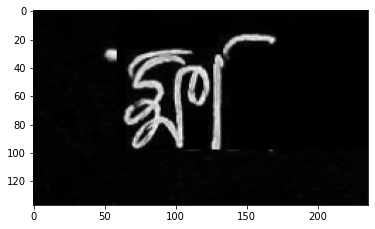

In [39]:
plt.imshow(inputs[5].permute(1, 2, 0).cpu())

In [40]:
logits = model(inputs)

In [41]:

grapheme = logits[:,:168]
vowel = logits[:, 168:179]
cons = logits[:, 179:]

In [42]:
loss1 = loss_fn(grapheme, targets_gra) * lam + loss_fn(grapheme, shuffled_targets_gra) * (1. - lam)
loss2 = loss_fn(vowel, targets_vow) * lam + loss_fn(vowel, shuffled_targets_vow) * (1. - lam)
loss3 = loss_fn(cons, targets_con) * lam + loss_fn(cons, shuffled_targets_con) * (1. - lam)

In [43]:
loss = 0.5 * loss1 + 0.25 * loss2 + 0.25 * loss3

In [ ]:
for e in range(100):
    train_loss = []
    model.train()

    for inputs, targets in tqdm(trn_loader):
        inputs = inputs.cuda()
        targets = targets.cuda()
        
        if np.random.rand() < 0.5:
            logits = model(inputs)
            grapheme = logits[:, :168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]

            loss = loss_fn(grapheme, targets[:, 0]) + loss_fn(vowel, targets[:, 1]) + loss_fn(cons, targets[:, 2])

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())
        else:
            
            lam = np.random.beta(1.0, 1.0) 
            rand_index = torch.randperm(inputs.size()[0])
            
            targets_gra = targets[:, 0]
            targets_vow = targets[:, 1]
            targets_con = targets[:, 2]
            
            shuffled_targets_gra = targets_gra[rand_index]
            shuffled_targets_vow = targets_vow[rand_index]
            shuffled_targets_con = targets_con[rand_index]
            
            bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
            inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
            
            logits = model(inputs)

            grapheme = logits[:,:168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]
            
            loss1 = loss_fn(grapheme, targets_gra) * lam + loss_fn(grapheme, shuffled_targets_gra) * (1. - lam)
            loss2 = loss_fn(vowel, targets_vow) * lam + loss_fn(vowel, shuffled_targets_vow) * (1. - lam)
            loss3 = loss_fn(cons, targets_con) * lam + loss_fn(cons, shuffled_targets_con) * (1. - lam)
            
            loss = 0.5 * loss1 + 0.25 * loss2 + 0.25 * loss3
            
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())
            
            
            
            
    val_loss = []
    val_true = []
    val_pred = []

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(vld_loader):
            inputs = inputs.cuda()
            targets = targets.cuda()

            logits = model(inputs)

            grapheme = logits[:, :168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]

            loss = loss_fn(grapheme, targets[:, 0]) + loss_fn(vowel, targets[:, 1]) + loss_fn(cons, targets[:, 2])

            val_loss.append(loss.item())

            grapheme = grapheme.cpu().argmax(dim=1).data.numpy()
            vowel = vowel.cpu().argmax(dim=1).data.numpy()
            cons = cons.cpu().argmax(dim=1).data.numpy()

            val_true.append(targets.cpu().numpy())
            val_pred.append(np.stack([grapheme, vowel, cons], axis=1))

    val_true = np.concatenate(val_true)
    val_pred = np.concatenate(val_pred)

    val_loss = np.mean(val_loss)
    train_loss = np.mean(train_loss)

    score_g = recall_score(val_true[:, 0], val_pred[:, 0], average='macro')
    score_v = recall_score(val_true[:, 1], val_pred[:, 1], average='macro')
    score_c = recall_score(val_true[:, 2], val_pred[:, 2], average='macro')

    final_score = np.average([score_g, score_v, score_c], weights=[2, 1, 1])

    print(f'train_loss: {train_loss:.5f}; val_loss: {val_loss:.5f}; score: {final_score:.5f}')
    print(f'score_g: {score_g:.5f}; score_v: {score_v: .5f}, score_c: {score_c: .5f}')



    if final_score > best_score:
        best_score = final_score

        state_dict = model.cpu().state_dict()
        model = model.cuda()
        torch.save(state_dict, "model.pt")